In [1]:
import preprocessor
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
args = preprocessor.load_args()
data = preprocessor.get_data_paths(os.path.join(args['data_dir'], 'renamed'))
resizer = preprocessor.Resizer()
image, label, name = preprocessor.process_single_pair(data[0][0], data[0][1], resizer)
preprocessor.save_data(image, label, name)

In [3]:
def draw_bbox(image, labels):
    src = np.array(image.copy())
    h, w, _ = src.shape
    for line in labels:
        label, cx, cy, bx, by = line

        x1 = int((cx - bx/2) * w)
        x2 = int((cx + bx/2) * w)
        y1 = int((cy - by/2) * h)
        y2 = int((cy + by/2) * h)

        cv2.rectangle(src, (x1, y1), (x2, y2), (255, 0, 0), 3)
    plt.imshow(src)

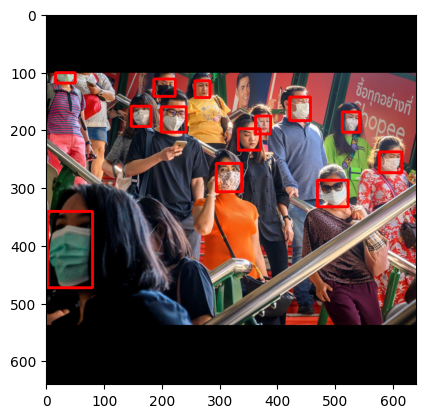

In [4]:
draw_bbox(image, label)

In [5]:
a = Image.open('/mask_recognition/data/dataset_kaggle_Face_Mask_Dataset_YOLO_Format/processed/0.jpg')
b = preprocessor.load_yolo_label('/mask_recognition/data/dataset_kaggle_Face_Mask_Dataset_YOLO_Format/processed/0.txt')

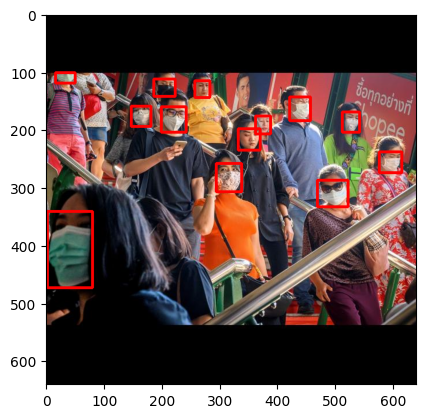

In [6]:
draw_bbox(a, b)

In [ ]:
preprocessor.save_data()

In [2]:
from pathlib import Path
import random
import shutil

In [3]:
args = preprocessor.load_args()

In [6]:
data_dir_str = args['data_dir']
data_dir_str

'/mask_recognition/data/dataset_kaggle_Face_Mask_Dataset_YOLO_Format'

In [ ]:
def data_split(data_dir: str, ratios: tuple[float, float, float], seed: int = 42) -> None:
    tr, va, te = ratios
    if abs((tr + va + te) - 1.0) > 1e-8:
        raise ValueError("(train + valid + test) must sum to 1.0")

    src = Path(data_dir) / "processed"
    if not src.exists():
        raise FileNotFoundError(f"{src} not found. Run preprocess first.")

    # (jpg, txt) 페어 수집
    jpgs = sorted(src.glob("*.jpg"))
    pairs = [(jpg, jpg.with_suffix(".txt")) for jpg in jpgs]

    # 인덱스 셔플
    idx = list(range(len(pairs)))
    rng = random.Random(seed)
    rng.shuffle(idx)

    n = len(idx)
    n_tr = int(n * tr)
    n_va = int(n * va)

    tr_idx = idx[:n_tr]
    va_idx = idx[n_tr:n_tr + n_va]
    te_idx = idx[n_tr + n_va:]

    # YOLO 디렉토리 생성 함수
    def make_yolo_dirs(root: Path):
        (root / "images").mkdir(parents=True, exist_ok=True)
        (root / "labels").mkdir(parents=True, exist_ok=True)

    out_root = Path(data_dir) / "final"
    out_train = out_root / "train"
    out_valid = out_root / "valid"
    out_test = out_root / "test"

    for d in (out_train, out_valid, out_test):
        make_yolo_dirs(d)

    # 복사 함수
    def copy_pair(jpg_path: Path, txt_path: Path, out_root: Path):
        shutil.copy2(jpg_path, out_root / "images" / jpg_path.name)
        out_txt = out_root / "labels" / txt_path.name
        if txt_path.exists():
            shutil.copy2(txt_path, out_txt)
        else:
            out_txt.write_text("")  # 빈 라벨 파일 생성

    for i in tr_idx:
        copy_pair(*pairs[i], out_train)
    for i in va_idx:
        copy_pair(*pairs[i], out_valid)
    for i in te_idx:
        copy_pair(*pairs[i], out_test)

    print(f"[DONE] total: {n} -> train: {len(tr_idx)}, valid: {len(va_idx)}, test: {len(te_idx)}")
